In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Lada.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Kalina,Seri_Samara,Seri_VAZ,Seri_Vega,Model_1.3,Model_1.5,Model_1.6,Model_2105.0,Model_2107.0,Yakıt Tipi_Benzin,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz
0,102000,2001,77,1499,300000,NaN,NaN,0,0,0,1,0,1,0,0,0,1,0,1
1,75000,1993,68,1499,135434,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,1
2,130000,2000,77,1499,164000,NaN,NaN,0,0,0,1,0,1,0,0,0,0,1,1
3,186000,2007,80,1596,185000,8.0,0.0,1,0,0,0,0,0,1,0,0,0,1,1
4,80000,1992,68,1499,530000,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_11996\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,23711.51452,7.545074e+08,27468.298757,22182.750854


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:14:51,695] A new study created in memory with name: no-name-e6af9042-8afb-462a-a86b-87e01d6750da
[I 2023-10-08 14:14:51,785] Trial 0 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.003970398567309856, 'max_depth': 7, 'min_child_weight': 150}. Best is trial 0 with value: 126353.73079028969.
[I 2023-10-08 14:14:51,792] Trial 1 finished with value: 126052.35592123942 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.00028988084997660517, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 1 with value: 126052.35592123942.
[I 2023-10-08 14:14:51,813] Trial 4 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.00044745927299661776, 'max_depth': 11, 'min_child_weight': 281}. Best is trial 1 with value: 126052.35592123942.
[I 2023-10-08 14:14:51,813] Trial 2 finished with value: 126353.73079028969 and paramet

[I 2023-10-08 14:14:52,717] Trial 28 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.49355461585672605, 'max_depth': 12, 'min_child_weight': 194}. Best is trial 17 with value: 37763.742478434775.
[I 2023-10-08 14:14:52,793] Trial 29 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.49040723873618697, 'max_depth': 12, 'min_child_weight': 130}. Best is trial 17 with value: 37763.742478434775.
[I 2023-10-08 14:14:52,801] Trial 31 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.4903498817890879, 'max_depth': 12, 'min_child_weight': 126}. Best is trial 17 with value: 37763.742478434775.
[I 2023-10-08 14:14:52,969] Trial 34 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1623465791465507, 'max_depth': 12, 'min_chil

[I 2023-10-08 14:14:54,665] Trial 58 finished with value: 27731.481177029975 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.24327078166060334, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 59 with value: 24355.599740909824.
[I 2023-10-08 14:14:54,881] Trial 60 finished with value: 24980.35191520081 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3056618523366282, 'max_depth': 6, 'min_child_weight': 11}. Best is trial 59 with value: 24355.599740909824.
[I 2023-10-08 14:14:54,937] Trial 61 finished with value: 25297.521375521355 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.323499058969351, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 59 with value: 24355.599740909824.
[I 2023-10-08 14:14:54,985] Trial 62 finished with value: 24317.14139074664 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3356466536524517, 'max_depth': 6, 'min_child_weight': 1

[I 2023-10-08 14:14:56,753] Trial 89 finished with value: 21497.654771383663 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.4780244452474288, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:14:56,785] Trial 91 finished with value: 22138.99900828498 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.40973239556600694, 'max_depth': 3, 'min_child_weight': 22}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:14:56,801] Trial 90 finished with value: 22416.25765200779 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4313990668556464, 'max_depth': 3, 'min_child_weight': 23}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:14:56,889] Trial 92 finished with value: 26670.59295965193 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.44241725862477965, 'max_depth': 3, 'min_child_weight':

[I 2023-10-08 14:14:58,668] Trial 119 finished with value: 30318.641940181624 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3010453568397815, 'max_depth': 4, 'min_child_weight': 51}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:14:58,692] Trial 120 finished with value: 30779.435745376668 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2872401253953235, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:14:58,716] Trial 121 finished with value: 29675.84605720131 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2882741652098049, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:14:58,788] Trial 122 finished with value: 23607.969011625875 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.302875403346108, 'max_depth': 4, 'min_child_weigh

[I 2023-10-08 14:15:00,625] Trial 149 finished with value: 22262.829127880974 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4996955028644429, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:15:00,660] Trial 150 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4989962813011185, 'max_depth': 4, 'min_child_weight': 113}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:15:00,778] Trial 151 finished with value: 24074.150074521905 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4806433541267893, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:15:00,813] Trial 152 finished with value: 23482.069975836082 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.46811208185962633, 'max_depth': 4, 'min_child_w

[I 2023-10-08 14:15:02,584] Trial 180 finished with value: 79631.27831305521 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.05529453011962178, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:15:02,607] Trial 179 finished with value: 26965.5468005083 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2503916267371862, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:15:02,729] Trial 181 finished with value: 22238.947122290312 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.40187992295045816, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 89 with value: 21497.654771383663.
[I 2023-10-08 14:15:02,764] Trial 182 finished with value: 22562.89269500552 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.41409525767637073, 'max_depth': 4, 'min_child_weight

[I 2023-10-08 14:15:04,945] Trial 208 finished with value: 21963.22521090848 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.42473039417797537, 'max_depth': 5, 'min_child_weight': 27}. Best is trial 202 with value: 21308.560567705015.
[I 2023-10-08 14:15:05,065] Trial 210 finished with value: 21436.134245775393 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.44071174649835193, 'max_depth': 6, 'min_child_weight': 24}. Best is trial 202 with value: 21308.560567705015.
[I 2023-10-08 14:15:05,097] Trial 212 finished with value: 22945.452761479828 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.34681202003583056, 'max_depth': 6, 'min_child_weight': 25}. Best is trial 202 with value: 21308.560567705015.
[I 2023-10-08 14:15:05,105] Trial 211 finished with value: 22961.980970945195 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.34273925046549536, 'max_depth': 6, 'min_chi

[I 2023-10-08 14:15:07,410] Trial 239 finished with value: 23515.89928052605 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3295595242336899, 'max_depth': 5, 'min_child_weight': 24}. Best is trial 202 with value: 21308.560567705015.
[I 2023-10-08 14:15:07,522] Trial 240 finished with value: 57341.39451528193 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.09565381446131707, 'max_depth': 6, 'min_child_weight': 24}. Best is trial 202 with value: 21308.560567705015.
[I 2023-10-08 14:15:07,546] Trial 241 finished with value: 24180.12338328689 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.29875470164735396, 'max_depth': 6, 'min_child_weight': 25}. Best is trial 202 with value: 21308.560567705015.
[I 2023-10-08 14:15:07,650] Trial 242 finished with value: 24439.344703269748 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.28537475980443205, 'max_depth': 6, 'min_child_

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 21308.5606
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.4684041168301335
	max_depth: 3
	min_child_weight: 27


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 21530.605186326495, 'MSE': 515994766.8365917, 'RMSE': 22715.518194322394, 'MAE': 17619.248291015625}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.5409529912338025

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.4773926361738674

In [16]:
marka_model = joblib.dump(final_model, "Lada.pkl")

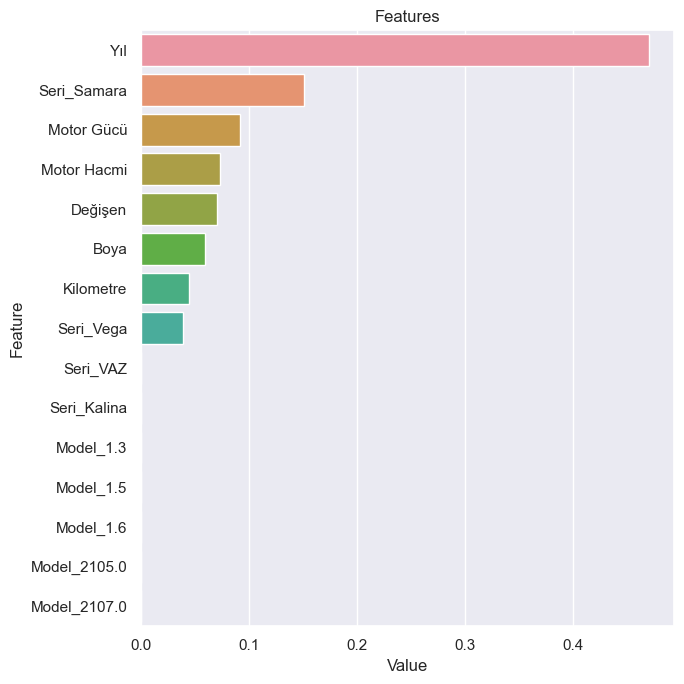

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)